In [1]:
import numpy as np
import os
import time
import pprint
import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import response_curves, tuning_curves

import nengo
from nengo.processes import WhiteSignal
from nengo.dists import Distribution, UniformHypersphere
from scipy.special import beta, betainc, betaincinv
from scipy.linalg import svd

from IK import viper300
from utilities import *
from nengo.neurons import Direct, LIF

import nengo_loihi
os.environ["KAPOHOBAY"] = "1"
nengo_loihi.set_defaults()

probes_on=True
n_scale=1000
np.random.seed(0)

abg_target = [0, 0, 0]
control_dof = [True,True,True,False,False,False]
velocity_delta = 0.005


def get_xyz_numeric_3d(axis):
    return np.array([axis[0][0],axis[1][0],axis[2][0]])

def in_limit(target):
    if target[1] <= -0.15: # Y axis limit
        if target[0] >= 0.24: # X axis limit
            print("You have reached a limit!")
            return False
    
    return True

def get_intercepts(n_neurons, dimensions):

    triangular = np.random.triangular(left=0.4, 
                                      mode=0.5, 
                                      right=0.6, 
                                      size=n_neurons)
    intercepts = nengo.dists.CosineSimilarity(dimensions + 2).ppf(1 - triangular)
    return intercepts
    
ik_model = viper300()

#position   = [0.0, 0.0, 0.0, 0.0, 0.0]
#xyz_current = get_xyz_numeric_3d(ik_model.get_xyz_numeric(position))
#target_xyz = [0.667, 0.318, 0.2]

position   = [-0.10128341, 0.61041507, 0.17557962, 3.16985, 0.78686707] 
xyz_current = get_xyz_numeric_3d(ik_model.get_xyz_numeric(position))
target_xyz = [0.02583485, 0.7, 0.60962662]


# Drinking - Target - try to move right

position   = [-0.03490659 ,-0.85521133,  0.85521133,  4.62512252, -1.30899694]
xyz_current = get_xyz_numeric_3d(ik_model.get_xyz_numeric(position))
target_xyz = [0.4, 0.61124887 ,0.28704582]
abg_target = [1.5707963267948966, -0.08726646259971632, -1.570796326794897]
control_dof = [True,True,True,True,True,True]


output_ = np.zeros(3)
output_direct = np.zeros(3)

def generate():
    np.random.seed(0)
    model = nengo.Network(seed=0)
    with model:

        def target_xyz_func(t):
            global target_xyz
            return target_xyz

        def current_xyz_func(t):
            global xyz_current
            return xyz_current

        model.axis = 3
        axis = model.axis  # the number axis
        model.probes_on = probes_on

       
        model.xyz_target = nengo.Node(target_xyz_func,   label='xyz_target')
        model.xyz_current = nengo.Node(current_xyz_func, label='xyz_current')
        
        model.diff = nengo.Ensemble(
            n_neurons=n_scale, dimensions=axis,
            radius=np.sqrt(axis),
            neuron_type=LIF(),
      #      intercepts=get_intercepts(n_scale, axis)
            )
        
        model.diff_direct = nengo.Ensemble(
            n_neurons=n_scale, dimensions=axis,
            radius=np.sqrt(axis),
            neuron_type=Direct(),
            )
        
        nengo.Connection(model.xyz_target,  model.diff)     
        nengo.Connection(model.xyz_current, model.diff, transform=-1) 
        
        nengo.Connection(model.xyz_target,  model.diff_direct)     
        nengo.Connection(model.xyz_current, model.diff_direct, transform=-1) 

        
        model.probe_diff   = nengo.Probe(model.diff, synapse=0.05)
        model.probe_diff_direct   = nengo.Probe(model.diff_direct, synapse=0.05)
        model.probe_diff_n  = nengo.Probe(model.diff.neurons)
        

        def output_func(t, x):
            global output_
            global xyz_current
            global position
            global abg_target
            global control_dof
            global velocity_delta
            
            output_ = np.copy(x)
            target = target_xyz + abg_target
            error = np.sqrt(sum((output_)**2))
            direction = np.zeros(6)
            direction[:3] = output_
            if np.sum(control_dof[3:]) > 0:
                R_e = ik_model.calculate_R(position)
                direction[3:] = calc_orientation_forces(target[3:], R_e)

            direction = direction[control_dof]

            J = ik_model.calc_J_numeric(position)
            J = J[control_dof]

            updated_position = (np.dot(np.linalg.pinv(J), direction)*velocity_delta)
            position += updated_position

            updated_current = get_xyz_numeric_3d(ik_model.get_xyz_numeric(position))

            xyz_current = updated_current

            
        output = nengo.Node(output_func, size_in=axis, size_out=0)
        
        nengo.Connection(model.diff, output) 

    return model
    

def plot_rasters(t, data):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    rasterplot(t, data[model.probe_diff_n])
    plt.title("diff ensemble, n_neurons={}".format(model.diff.n_neurons))
    plt.ylabel("Neuron number")
    plt.xticks(())
    plt.xlabel("Time (s)")
    plt.tight_layout()

In [2]:
model = generate()
print("xyz_current: ",xyz_current)
print("xyz_target: ",target_xyz)

xyz_current:  [0.22161532 0.61124887 0.28704582]
xyz_target:  [0.4, 0.61124887, 0.28704582]


In [3]:
with nengo_loihi.Simulator(model,remove_passthrough=False, target='loihi', hardware_options={
    "snip_max_spikes_per_step": 350
}) as sim_loihi:
    sim_loihi.run(0.05)


INFO:DRV:  Connecting to 127.0.0.1:34281
INFO:DRV:      Host server up..............Done 1.73s
INFO:DRV:      Encoding axons/synapses.....Done 0.07s
INFO:DRV:      Compiling Embedded snips....Done 0.10s
INFO:DRV:      Booting up..................Done 2.94s
INFO:DRV:      Encoding probes.............Done 2.11ms
INFO:DRV:      Transferring probes.........Done 5.41ms
INFO:DRV:      Configuring registers.......Done 0.12s
INFO:DRV:      Transferring spikes.........Done 6.04ms
INFO:DRV:      Executing...................Done 1.00s
INFO:DRV:      Processing timeseries.......Done 0.01s
INFO:DRV:  Executor: 50 timesteps..........Done 1.15s
INFO:HST:  Using Kapoho Bay serial number 433
INFO:HST:  Args chip=0 cpu=0 /home/yuval/NBEL/loihi_env_36/lib/python3.6/site-packages/nxsdk/driver/compilers/../../../temp/1629788707.6513608/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 
INFO:HST:  Lakemont_driver...
INFO:HST:  chip=0 cpu=0 halted, status=0x0


xyz_current:  [0.25280985 0.60864779 0.28932128]
xyz_target:  [0.4, 0.61124887, 0.28704582]


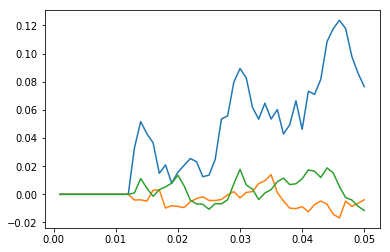

In [4]:
plt.figure()
plt.plot(sim_loihi.trange(), sim_loihi.data[model.probe_diff])
print("xyz_current: ",xyz_current)
print("xyz_target: ",target_xyz)

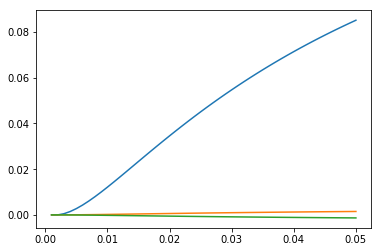

In [7]:
plt.figure()
plt.plot(sim_loihi.trange(), sim_loihi.data[model.probe_diff_direct])

In [132]:
model = generate()

In [133]:
sim = nengo.Simulator(model, dt=0.001, optimize=True)
sim.run(2, progress_bar=True)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

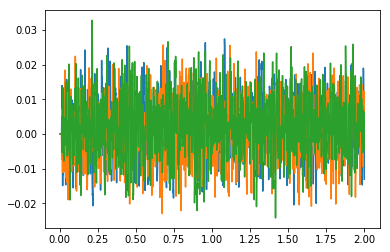

In [134]:
plt.figure()
plt.plot(sim.trange(), sim.data[model.probe_diff])

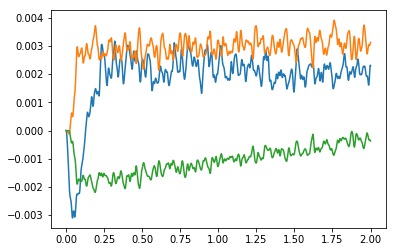

In [135]:
plt.figure()
plt.plot(sim.trange(), sim.data[model.probe_diff_direct])